# 💊 Drug Detection

## Preprocessing

* Dropping duplicates (Also performed during Final Dataset creation)
* Dropping missing or infinite values (Also performed during Final Dataset creation)
* Split the Data into Train(80%) and Test set(20%)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("Dataset/final/dataset.csv")

# Drop duplicates (SMILES-based)
df.drop_duplicates(subset=["smiles"], keep="first", inplace=True)

# Drop full duplicate rows if any
df.drop_duplicates(inplace=True)

# Drop rows with NaN or ±inf in any column
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Split features and target
x = df.drop(columns=["smiles", "Is Drug"])
y = df["Is Drug"]

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (9442, 2221)
x_test shape: (2361, 2221)
y_train shape: (9442,)
y_test shape: (2361,)


### Visualize distributions (boxplot + histogram) of physicochemical features

  The distributions are heavily right skewed(_except for clogP and Ring Count_) and has many outliers.

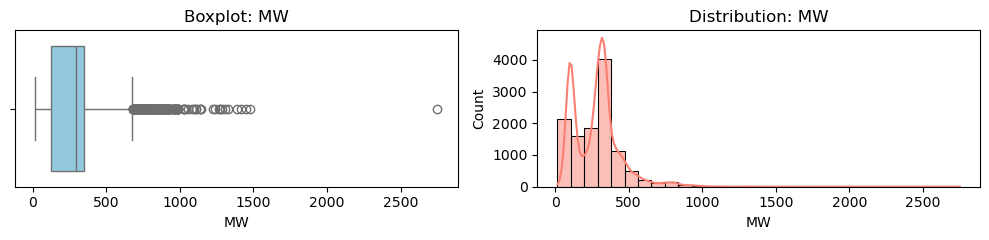

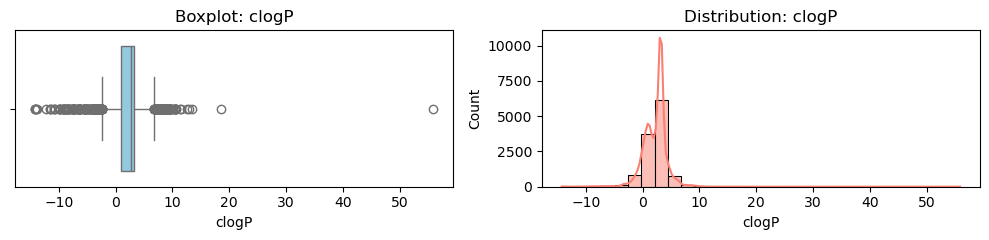

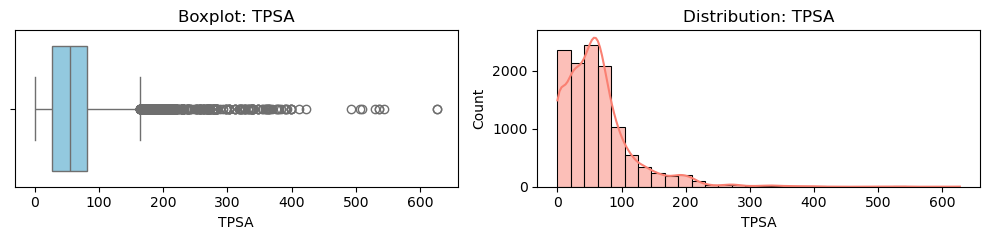

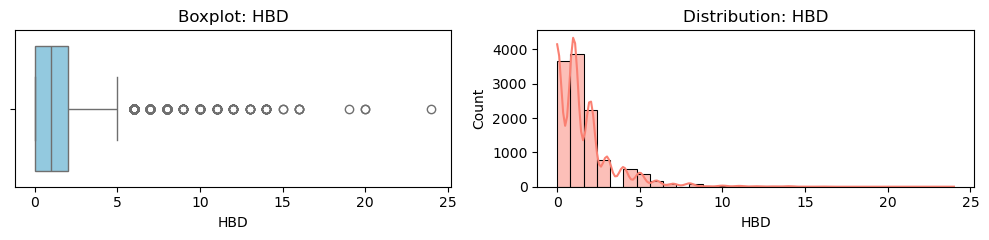

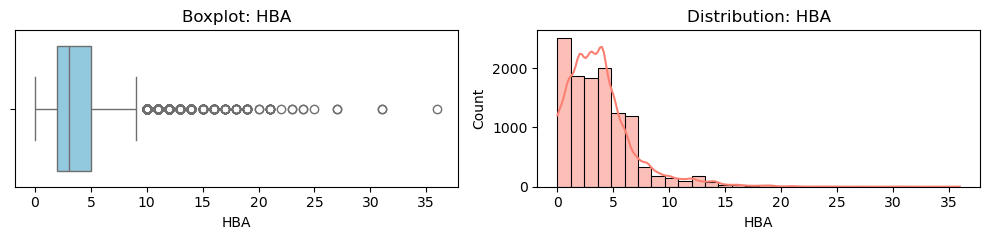

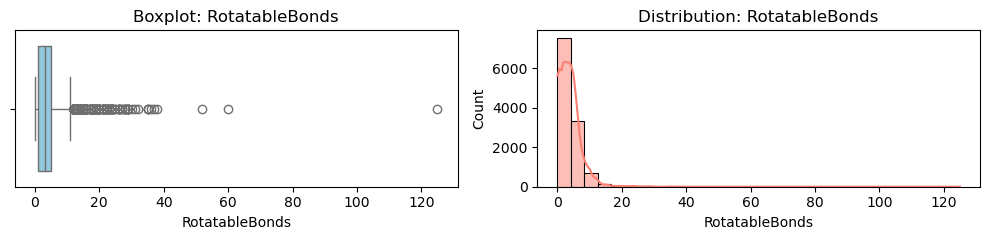

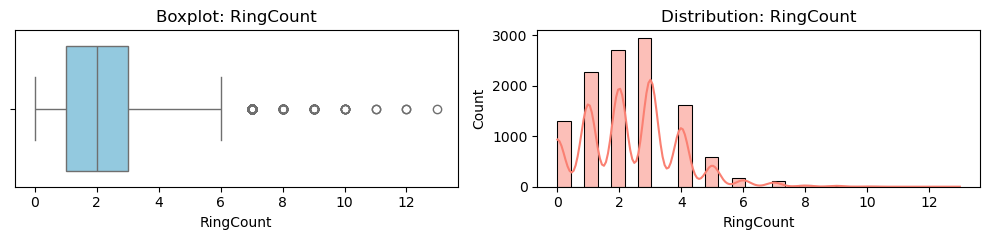

In [2]:
physicochemical_features = [
    "MW","clogP","TPSA","HBD","HBA","RotatableBonds","RingCount"
]

for feature in physicochemical_features:

    fig, axes = plt.subplots(1, 2, figsize=(10, 2.5))

    # Boxplot
    sns.boxplot(x=x[feature], ax=axes[0], color='skyblue')
    axes[0].set_title(f'Boxplot: {feature}')

    # Histogram + KDE
    sns.histplot(x[feature], kde=True, bins=30, ax=axes[1], color='salmon')
    axes[1].set_title(f'Distribution: {feature}')

    plt.tight_layout()
    plt.show()

### Scaling

* Applies np.log1p() to skewed descriptors

* Leaves clogP and RingCount untouched since they are not heavily skewed

* Uses RobustScaler on all 7 descriptors

* Leaves ECFP4 and MACCS untouched since they are binary (0/1) values

* Outputs x_train_scaled, x_test_scaled

In [3]:
from sklearn.preprocessing import RobustScaler

log_transform_features = ["MW", "TPSA", "HBD", "HBA", "RotatableBonds"]  # Exclude clogP and RingCount

x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()
x_train_scaled[log_transform_features] = x_train_scaled[log_transform_features].apply(np.log1p)
x_test_scaled[log_transform_features] = x_test_scaled[log_transform_features].apply(np.log1p)

# === 7. Apply RobustScaler ONLY on the 7 descriptors ===
scaler = RobustScaler()
x_train_scaled[physicochemical_features] = scaler.fit_transform(x_train_scaled[physicochemical_features])
x_test_scaled[physicochemical_features] = scaler.transform(x_test_scaled[physicochemical_features])

# === 8. Final output ===
# x_train_log and x_test_log contain full scaled feature sets: descriptors + untouched fingerprints
print("✅ Preprocessing complete.")
print("x_train shape:", x_train_scaled.shape)
print("x_test shape:", x_test_scaled.shape)

✅ Preprocessing complete.
x_train shape: (9442, 2221)
x_test shape: (2361, 2221)


### Dimensionality Reduction

Reducing ECFP4 + MACCS dimensions and combining them with the already-scaled descriptors:

In [4]:
from sklearn.feature_selection import VarianceThreshold

# === 1. Identify fingerprint columns
descriptor_cols = ["MW", "clogP", "TPSA", "HBD", "HBA", "RotatableBonds", "RingCount"]
fingerprint_cols = [col for col in x_train.columns if col not in descriptor_cols]

# === 2. Apply VarianceThreshold on fingerprint columns
vt = VarianceThreshold(threshold=0.01)
x_train_fp_reduced = vt.fit_transform(x_train_scaled[fingerprint_cols])
x_test_fp_reduced = vt.transform(x_test_scaled[fingerprint_cols])

# === 3. Combine reduced fingerprints with scaled descriptors
x_train_final = np.concatenate([x_train_scaled[descriptor_cols].values, x_train_fp_reduced], axis=1)
x_test_final = np.concatenate([x_test_scaled[descriptor_cols].values, x_test_fp_reduced], axis=1)

print("✅ Fingerprint reduction complete.")
print(f"Original fingerprint count: {len(fingerprint_cols)}")
print(f"Reduced fingerprint count: {x_train_fp_reduced.shape[1]}")
print(f"Final feature shape: {x_train_final.shape}")


✅ Fingerprint reduction complete.
Original fingerprint count: 2214
Reduced fingerprint count: 875
Final feature shape: (9442, 882)


### Feature Selection with SelectKBest(f_classif)

* This selects the 300 best features based on their statistical relationship to the target.

* It works well for high-dimensional datasets like these, especially with many sparse/binary features.

In [5]:
from sklearn.feature_selection import SelectKBest, f_classif

# === Select top 300 most informative features (based on ANOVA F-test) ===
selector = SelectKBest(score_func=f_classif, k=300)
x_train_selected = selector.fit_transform(x_train_final, y_train)
x_test_selected = selector.transform(x_test_final)

print("✅ Feature selection complete.")
print("Original feature count:", x_train_final.shape[1])
print("Selected feature count:", x_train_selected.shape[1])


✅ Feature selection complete.
Original feature count: 882
Selected feature count: 300


### 🔁 Cross-Validation (Train Set Only)

We perform 5-fold cross-validation using only the training data to estimate the model's generalization performance without data leakage. ROC-AUC is used as the scoring metric.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Reinitialize model
model_cv = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=1000)

# Perform 5-fold CV on training set only
cv_scores = cross_val_score(model_cv, x_train_selected, y_train, cv=5, scoring='roc_auc')

print("Cross-Validation ROC-AUC scores (train set only):", cv_scores)
print(f"Mean AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-Validation ROC-AUC scores (train set only): [0.97104183 0.97193413 0.96981157 0.97131975 0.9630034 ]
Mean AUC: 0.9694 ± 0.0033


### 🧪 Final Model Training and Evaluation on Held-out Test Set

After performing cross-validation and selecting the best model configuration, we now train the model on the entire training set and evaluate its performance on the held-out test set.

This provides an unbiased estimate of the model’s real-world predictive ability.

Metrics evaluated:
- ROC-AUC Score
- ROC Curve visualization
- Precision, Recall, F1-score (via classification report)
- Confusion Matrix (in earlier cell)


Test ROC-AUC Score: 0.9721


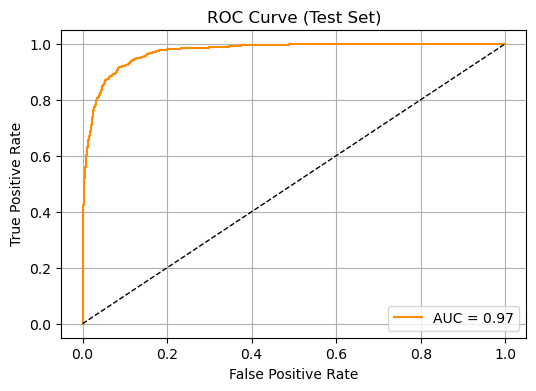


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1181
           1       0.91      0.91      0.91      1180

    accuracy                           0.91      2361
   macro avg       0.91      0.91      0.91      2361
weighted avg       0.91      0.91      0.91      2361



In [7]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt

# Fit the model on full training set
final_model = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=1000)
final_model.fit(x_train_selected, y_train)

# Predict probabilities on test set
y_proba = final_model.predict_proba(x_test_selected)[:, 1]

# ROC-AUC Score
test_auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC-AUC Score: {test_auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

# Classification Report
y_pred = final_model.predict(x_test_selected)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


### 🔍 Confusion Matrix Visualization

We visualize both:
- **Raw confusion matrix** to show absolute prediction counts
- **Normalized confusion matrix** to highlight class-wise prediction accuracy

This helps interpret model behavior on each class more intuitively.

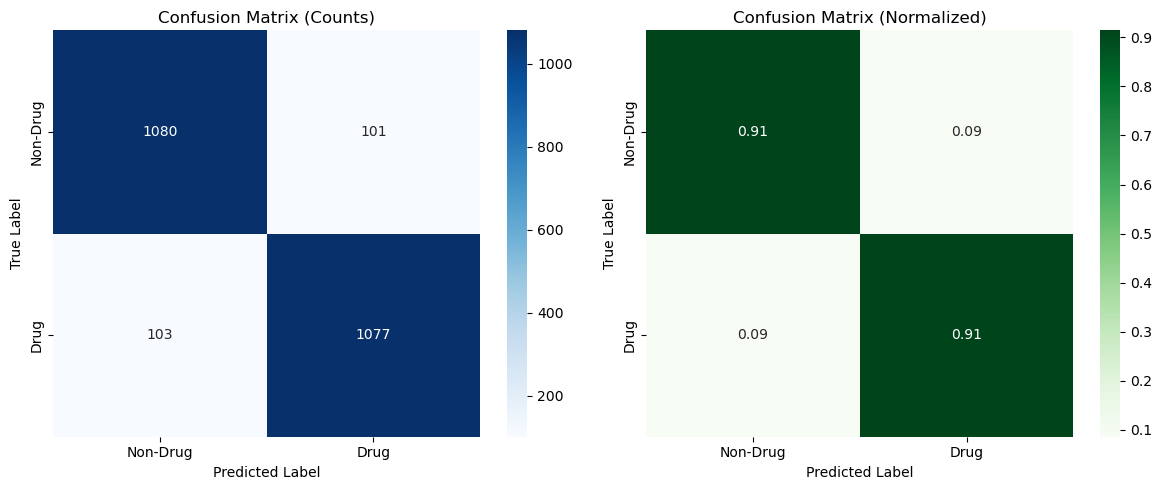

In [8]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Predict test labels
y_pred = final_model.predict(x_test_selected)

# Confusion matrices
cm_raw = confusion_matrix(y_test, y_pred)
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')  # row-wise normalization

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw counts
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Drug", "Drug"], yticklabels=["Non-Drug", "Drug"], ax=axes[0])
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Normalized
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=["Non-Drug", "Drug"], yticklabels=["Non-Drug", "Drug"], ax=axes[1])
axes[1].set_title("Confusion Matrix (Normalized)")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()


### 🔍 Feature Importance – Top Contributing Features

Below are the top 15 features (fingerprints or descriptors) that most influence the logistic regression model. Positive coefficients push predictions toward "Drug", while negative values push toward "Non-Drug".


        Feature  Coefficient
227    MACCS_56    -3.427266
220    MACCS_49     3.087078
0            MW     2.552291
254   MACCS_103     2.484691
193  ECFP4_1963    -2.441129
210    MACCS_26     2.070691
182  ECFP4_1859    -2.063544
52    ECFP4_561    -1.940999
211    MACCS_29     1.882961
269   MACCS_125    -1.830683
249    MACCS_94    -1.585713
232    MACCS_63     1.509395
154  ECFP4_1585     1.478220
212    MACCS_30     1.446434
152  ECFP4_1542    -1.443796


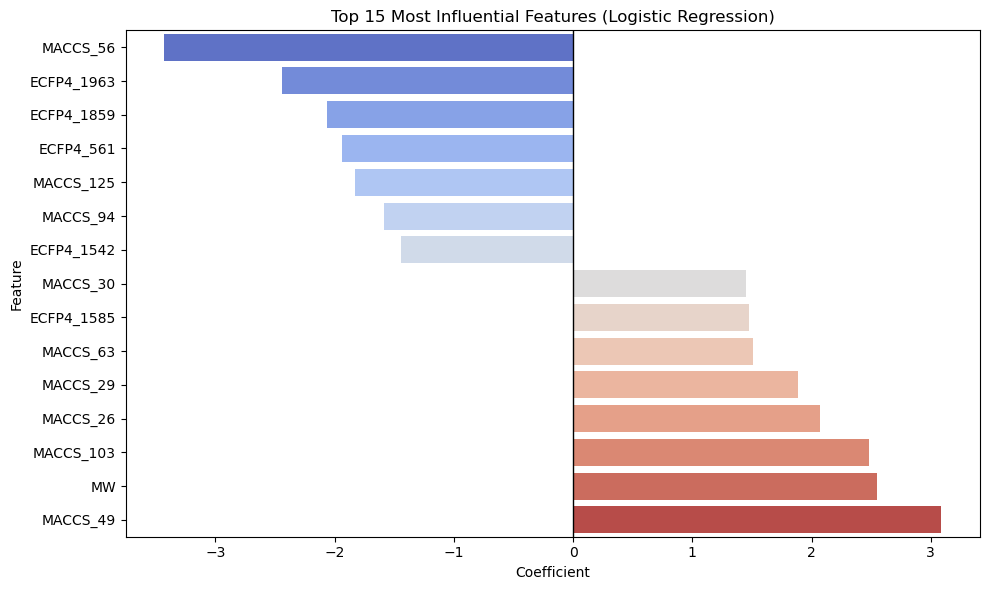

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get final list of selected features (after SelectKBest)
selected_feature_indices = selector.get_support(indices=True)

# Build combined feature name list: descriptors + reduced fingerprints
descriptor_names = x_train_scaled[descriptor_cols].columns.tolist()
fingerprint_names = vt.get_feature_names_out(input_features=fingerprint_cols).tolist()

# Combine names (same order as in x_train_final before SelectKBest)
combined_feature_names = descriptor_names + fingerprint_names

# Now get only those that survived SelectKBest
selected_feature_names = [combined_feature_names[i] for i in selected_feature_indices]

# Map to model coefficients
coefficients = final_model.coef_[0]
feature_contributions = pd.DataFrame({
    'Feature': selected_feature_names,
    'Coefficient': coefficients,
    'Abs(Coefficient)': np.abs(coefficients)
})

# Sort by absolute contribution
top_features = feature_contributions.sort_values(by='Abs(Coefficient)', ascending=False).head(15)
print(top_features[['Feature', 'Coefficient']])

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_features.sort_values("Coefficient"),
    y="Feature",
    x="Coefficient",
    hue="Feature",
    dodge=False,
    palette="coolwarm",
    legend=False
)
plt.axvline(0, color='black', linewidth=1)
plt.title("Top 15 Most Influential Features (Logistic Regression)")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



### 💾 Exporting Model and Preprocessing Objects

To ensure consistent inference, we save all key components of the training pipeline:

- `RobustScaler`: for feature scaling after log transformation
- `VarianceThreshold`: to reduce sparse fingerprint dimensions
- `SelectKBest`: to retain the top 300 most informative features
- `LogisticRegression` model: the final trained classifier

These objects are exported using `joblib` and can later be reloaded to preprocess new SMILES-derived features and make predictions without retraining.


In [10]:
import joblib

joblib.dump(scaler, "Model/scaler.pkl")                # RobustScaler
joblib.dump(vt, "Model/variance_threshold.pkl")         # VarianceThreshold
joblib.dump(selector, "Model/selectkbest.pkl")          # SelectKBest
joblib.dump(final_model, "Model/final_model.pkl")       # Logistic Regression


['Model/final_model.pkl']